### 생성 모델을 위한 딥러닝
이번 Post에서는 예술 창작에 딥러닝이 어떻게 쓰일 수 있는지 다양한 각도에서 살펴본다.  
시퀀스 데이터 생성(글을 쓰거나 작곡할 수 있다.), 딥드립, 변이형 오토인코더, 적대적 생성 네트워크(GAN)을 사용한 이미지 생성을 알아본다.  

아래 링크는 이번 Post와 관련된 수식이나 내용을 미리 정리해둔것 이므로 참고하면 좋다.  
1. <a href="https://wjddyd66.github.io/tensorflow/Tensorflow-AutoEncoder/">Tensorflow-AutoEncoder</a>, <a href="https://wjddyd66.github.io/pytorch/Pytorch-AutoEncoder/">Pytorch-AutoEncoder</a>
2. <a href="https://wjddyd66.github.io/tensorflow/Tensorflow-GAN/">Tensorflow-GAN</a>, <a href="https://wjddyd66.github.io/pytorch/Pytorch-GAN/">Pytorch-GAN</a>, <a href="https://wjddyd66.github.io/pytorch/Pytorch-DCGAN/">Pytorch-DCGAN</a>
3. <a href="https://wjddyd66.github.io/dl/seq2seq/">seq2seq</a>
4. <a href="https://wjddyd66.github.io/pytorch/Pytorch-StyleTransfer/">Pytorch-StyleTransfer</a>


#### 필요한 라이브러리 Import

In [2]:
import random
import sys
import time
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras import layers, Model
from keras.preprocessing.image import load_img, img_to_array, save_img
from keras.applications import vgg19
from keras import backend as K
from keras import metrics
from scipy.optimize import fmin_l_bfgs_b
from scipy.stats import norm

### LSTM을 텍스트 생성하기
**텍스트를 생성하는 LSTM Model**은 입력으로 몇개의 Character(N개)를 Input으로 받으면 Output으로서 하나의 Character를 생성하는 Model이다.    
<br>

#### 확률적인 방법 Sampling
**위와 같은 Model에서 가장먼저 해야하는 것은 OutputData를 어떻게 선택할 것인가? 이다.**  
OutputData를 선택하는 방법은 아래아 같이 크게 2가지로 나뉜다.  

1. 결정적인 방법: 결정적이란 결과가 하나로 정해지는 것, 결과가 예측가능한 것이다. 즉, 이번 Model에서의 결정적인 방법이란 Input Data에 대한 다음 단어 선택시 가장 확률이 높은 단어를 선택하는 것 이다.
2. 확률적인 방법: 확률적이란 결과가 확률에 따라 정해진다는 것이다. 즉, 이번 Model에서의 확률적인 방법이란 Input Data에 대한 다음 단어 선택 시 확률에 따라 단어를 선택하는 것 이다.

어떤 방법이 더 좋다는 것은 없다.  
하지만 1. 결정적인 방법을 선택하게 된다면 항상 같은 문장을 생성하고 결과를 확인하는 Model이 Training될 것이다.  
이와 반대로 2. 확률적인 방법으로서 Model을 Training하게 된다면 주어진 문장 외에도 다양한 학습을 하고 결과를 도출할 것이라고 예상할 수 있다.  

따라서 현재 Keras와 다른 예제에서는 텍스트 생성 LSTM Model을 구성할때 2. 확률적인 방법으로 많이 구성하고 결과를 확인한다.  

아래 Code는 original_distribution이라는 1 Dimension Array & 원소의 모든 합은 1인 Parameter를 입력받아서 특정 값을 출력하는 함수 이다.(원소의 모든 합이 1인 이유는 뒤에서 Model을 구성할 때 Softmax를 사용하기 때문이다.)  

출력하는 특정 값은 Temperature에 따라서 결과의 Entropy의 값이 변화된다.

In [14]:
def reweight_distribution(original_distribution, temperature=0.5):
    distribution = np.log(original_distribution) / temperature
    distribution = np.exp(distribution)
    return distribution/np.sum(distribution)

위의 Method를 수학적인 수식으로 선언하여 Temperature에 따라서 원소의 분포가 어떻게 변하는지 시각화하는 Code가 아래의 Code이다.  

**아래 Visualization의 결과를 확인하게 되면 Temperature의 값이 높아지면 높아질 수록 값의 다양성이 증가되는 Entropy의 값이 높아지는 것을 확인할 수 있다.**

1.0


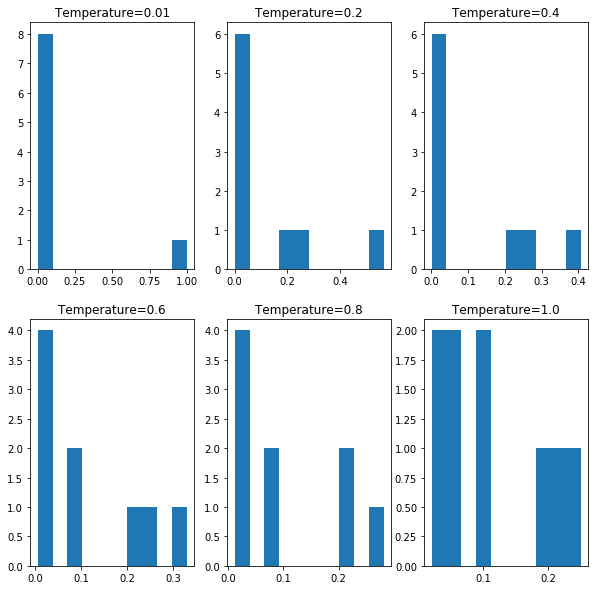

In [18]:
# 각 원소의 합이 1 인 1D Array 선언
example = np.array([0.05, 0.05, 0.2, 0.1, 0.1, 0.25, 0.02, 0.02, 0.21])
print(np.sum(example))

# 위에서 선언한 Array를 위에서 선언한 Temperature을 변화시키면서 확인
result_1 = reweight_distribution(example, temperature=0.01)
result_2 = reweight_distribution(example, temperature=0.2)
result_3 = reweight_distribution(example, temperature=0.4)
result_4 = reweight_distribution(example, temperature=0.6)
result_5 = reweight_distribution(example, temperature=0.8)
result_6 = reweight_distribution(example, temperature=1.0)

# 위에서 각각의 Temperature의 결과를 시각화하여 알아본다.
plt.figure(figsize=(10,10))

# Temperature = 0.01
plot_1 = plt.subplot(2,3,1)
plot_1.hist(result_1)
plot_1.set_title('Temperature=0.01')

# Temperature = 0.2
plot_2 = plt.subplot(2,3,2)
plot_2.hist(result_2)
plot_2.set_title('Temperature=0.2')

# Temperature = 0.4
plot_3 = plt.subplot(2,3,3)
plot_3.hist(result_3)
plot_3.set_title('Temperature=0.4')

# Temperature = 0.6
plot_4 = plt.subplot(2,3,4)
plot_4.hist(result_4)
plot_4.set_title('Temperature=0.6')

# Temperature = 0.8
plot_5 = plt.subplot(2,3,5)
plot_5.hist(result_5)
plot_5.set_title('Temperature=0.8')

# Temperature = 1.0
plot_6 = plt.subplot(2,3,6)
plot_6.hist(result_6)
plot_6.set_title('Temperature=1.0')

plt.show()

#### 데이터 준비
19세기의 니체의 글을 Text Data로서 선택하였다.  
아래의 Code는 이러한 Text Data를 사용하기 위하여 가져오는 단계이다.

In [21]:
path = keras.utils.get_file(
    'nietzsche.txt',
    origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')
text = open(path).read().lower()

print('말뭉치 크기:',len(text))

606208/600901 [==============================] - 3s 6us/step
말뭉치 크기: 600893


#### 데이터 전처리
결국에는 다운받은 데이터를 LSTM Model에 넣고 Training하기 위하여 데이터를 전처리 하는 과정이다.  
각각의 Parameter는 다음의 의미가 있다.  
- maxlen: Input Data Sequence의 Size
- step: Data의 글자 Term

즉 아래 Code는 maxlen=60, step=3으로서 선언하여서 60개의 Sequence를 Input Data 1개의 Character를 Target Data  
각각의 Sequence는 3글자씩 건너뛰어서 Dataset을 전처리하여 준비한다.  

각각의 Input Data와 Target Data는 One-Hot-Encoding으로서 표현한다.  

**참고사항**  
One-Hot_Encoding으로 맞추기 위하여 각각의 Character를 어떻게 Mapping할지에 대하여 정의하여야 한다.  
다음과 같은 과정으로서 Mapping하기 위한 Vectoer를 준비한다.
1. 위의 데이터 준비 단계에서 Text를 전부 소문자로서 바꾼다.
2. Python set 자료구조를 통하여 중복되는 Character는 제외시킨다.
3. Python Dict 자료구조를 통하여 Character: Set Index로서 One-Hot-Encoding으로 Mapping하기 위한 Vocab을 정의한다.



In [24]:
# maxlen: Input Data Size, step: Input Data의 Term
maxlen=60
step=3

# setences: Input Data, next_chars: Target Data
setences = []
next_chars = []

# Input Data, Target Data 선언
for i in range(0,len(text)-maxlen,step):
    setences.append(text[i:i+maxlen])
    next_chars.append(text[i+maxlen])

print('시퀀스 개수', len(setences))

# Python Set 자료구조를 사용하여 중복되는 Character 제거
chars = sorted(list(set(text)))
print('고유한 글자:',len(chars))

# Python Dict 자료구조를 사용하여 Character:Index로서 Vocab File정의
char_indices = dict((char,chars.index(char)) for char in chars)

# One-Hot_Encoding
print('벡터화...')
x = np.zeros((len(setences),maxlen,len(chars)),dtype=np.bool)
y = np.zeros((len(setences),len(chars)),dtype=np.bool)

for i, setence in enumerate(setences):
    for t, char in enumerate(setence):
        x[i,t,char_indices[char]] = 1
        y[i,char_indices[next_chars[i]]] = 1

시퀀스 개수 200278
고유한 글자: 57
벡터화...


#### 텍스트 생성을 위한 LSTM Model
위에서 Data준비와 전처리를 전부 수행하였다.  
이제 실질적으로 텍스트 생성을 위한 LSTM Model을 정의한다.  
Input으로 Data가 들어왔을때 전체 Character의 개수 중에서 하나를 뽑는 Classification의 문제이므로 마지막단 Layer를 Softmax로서 선언한다.  
또한 True와 False로 이루워진 One-Hot-Encoding으로서 Data를 전처리 하였으므로 Loss를 구하기 위하여 Loss Function을 categorical_crossendtropy로서 구성한다.

In [28]:
model = keras.models.Sequential()
model.add(layers.LSTM(128,input_shape=(maxlen,len(chars))))
model.add(layers.Dense(len(chars),activation='softmax'))

optimizer = keras.optimizers.RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy',optimizer=optimizer)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               95232     
_________________________________________________________________
dense_3 (Dense)              (None, 57)                7353      
Total params: 102,585
Trainable params: 102,585
Non-trainable params: 0
_________________________________________________________________


#### Output Data Sampling
위에서 확률적인 Sampling을 위하여 reweight_distribution Function과 결과를 Temperature에 따라서 Visualization을 하여 확인하였다.  
아래의 **실질적인 Model에서 사용하는 Sampling은 Temperature에 따라 Entropy를 조절하는 것 까지는  reweight_distribution Function과 똑같으나 + 실질적으로 사용할 Character의 Index를 뽑는것 까지 추가하여다.**  
각각의 57개의 Character에 대한 확률 중 에서 확률에 따라 Random하게 Character를 뽑게 된다.  

Random하다라고 표현하였으나 일반적으로 생각하는 Random이 아니라 **Temperature와 상관없이 Target Character가 뽑힐 확률은 높으나 Temperature가 높아지면 높아질수록 Entropy는 증가하게 되고 따라서 다른 Character가 뽑힐 확률이 높아지는 것 이다.**  
우리가 일반적으로 생각하는 Random은 모든 확률이 같은 것 이다.

In [29]:
def sample(preds, temperature=1.0):
    # reweight_distribution와 같은 부분 확률 분포의 가중치를 조정
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    # 각각의 확률에 맞게 Character를 뽑아서 가장 높은 값의 Index를 추출한다.
    # Temperature가 높을수록 새로운 글자의 Index를 뽑을 확률이 높아진다.
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

#### Training & 텍스트 생성
정의한 Dataset과 Model을 통하여 Training 및 Training된 Model로서 다음 글자를 선택하는 결과를 보여준다.  

**최종적인 Model은 위에서 설명한 60개의 Input을 받고 1개의 Character을 뽑아내는 Model이다.**  
**이러한 1개의 Character를 400번 반복하게 되어서 결국에는 60개의 see_text를 통하여 400개의 Character를 추출하는 결과를 확인한다.**  

위에서 Sample Function은 이러한 400개의 Character를 추출할 때 확률적인 Sampling을 통하여 다음 글자를 Sampling하는데 사용된다.  

최종적인 결과를 확인하게 되면 Temperature가 낮으면 Training Data그대로 선택할 확률이 매우 높아서 원본과 비슷한 Text를 생성하게 될 것이다.  
**Epoch=30, Temperature=0.2**  
```code
------ 온도: 0.2
the slowly ascending ranks and classes, in which,
through for the most conscience and standation of the states of the stronger of the strongly and everything in the spirit of the moral and the moral and and account of the stronger of the morality of the spirit of the spirit of the spirit of the spirit of the states the most promate the problem to the strong and the strong and assumet to the moral and sense of the problem to the observe of the spirit of the
```
<br>

Temperature가 높으면 상대적으로 새로운 Character를 뽑을 확률이 높을 것이고 이러한 결과는 인간의 관점에서 바라볼 때 독창적인 Text를 생성한다고 생각할 수 있다.  
**Epoch=30, Temperature=1.2**  
```code
------ 온도: 1.2
the slowly ascending ranks and classes, in which,
through for which himself himself, bene thervelwnetest, is highy,
the could goal, i very plenessimmosly).
there as an eyes; pridious. co asgished, perhaps at all, and
in
the "becausenztkness,"
the galy. i wasse i purpod, teashesgale, pussce of all truchs--others. almost
injured on 'godol as
offender," almost eotions. asliven dece"nested forvelowar." outseld
taste" about us is armism, all preparation
our oot
```
<br>

원본책에서는 60번의 Epoch동안 Model을 Training하나 생각보다 시간이 오래 걸려서 30번의 Epoch동안 Training하고 결과를 확인하였습니다.

In [31]:
random.seed(42)
start_index = random.randint(0, len(text) - maxlen - 1)

# 30 에포크 동안 모델을 훈련합니다
for epoch in range(1, 30):
    print('에포크', epoch)
    
    # 데이터에서 한 번만 반복해서 모델을 학습합니다
    model.fit(x, y, batch_size=128, epochs=1)

    # 무작위로 시드 텍스트를 선택합니다
    seed_text = text[start_index: start_index + maxlen]
    print('--- 시드 텍스트: "' + seed_text + '"')

    # 여러가지 샘플링 온도를 시도합니다
    for temperature in [0.2, 0.5, 1.0, 1.2]:
        print('------ 온도:', temperature)
        generated_text = seed_text
        sys.stdout.write(generated_text)

        # 시드 텍스트에서 시작해서 400개의 글자를 생성합니다
        for i in range(400):
            # 지금까지 생성된 글자를 원-핫 인코딩으로 바꿉니다
            sampled = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.

            # 다음 글자를 샘플링합니다
            preds = model.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = chars[next_index]

            generated_text += next_char
            generated_text = generated_text[1:]

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

에포크 1
Epoch 1/1
200278/200278 [==============================] - 79s 396us/step - loss: 1.6345
--- 시드 텍스트: "the slowly ascending ranks and classes, in which,
through fo"
------ 온도: 0.2
the slowly ascending ranks and classes, in which,
through for the spirit of the strange of the self this are and present and the strange and the self thing the state of the self be the man and the states of the self present and man has a stinder and the man and things and things and the present and the man and the believe that the self things and an an an an an an an an an an an an an an an one who sense of the self an an an an an an oneself and the presen
------ 온도: 0.5
the slowly ascending ranks and classes, in which,
through for the world a concemain of more one and proventing of continting to an an the belief the art of the spirits and more of the can ble and problem the
expresses, to the other has longer and present things and an an an overlard and to man and provent of the education, and the god an

understumably, like what thouealips thus will by
himself despectably yes. copencion of the indigned ac" to lacke of those who schopenhauer's new--awgered, the
schoblittersed from that
what soeld ay the actions
to their heart man.

     the all more
that 
에포크 9
Epoch 1/1
200278/200278 [==============================] - 80s 400us/step - loss: 1.3770
--- 시드 텍스트: "the slowly ascending ranks and classes, in which,
through fo"
------ 온도: 0.2
the slowly ascending ranks and classes, in which,
through for the superiority of the most souls of the superious and souls of the sense of the states of the superiority of the superiority of the superiority of the soul, and the states of the superiority of the probably and an and responsibility of the states to the sense of the superiority of the states of the states of the states to the still and the states and the world of the superiority of the superior
------ 온도: 0.5
the slowly ascending ranks and classes, in which,
through for the science. the most 

of there passe, a 
------ 온도: 1.2
the slowly ascending ranks and classes, in which,
through for year-unoccaus his masconant and xhaste
by the bledicuat, limiwe to the sacrifite himself, have darmed of owet for these mignor nowils, ut, which
cleriful- up", through the child that was often could hughic and indispectted menejorver
soulriprobes an
aulrrofnes. nevertheless is anyone notound sometely be loves! thall back
stepeness is have
does neuses distrusts and tar facts to practicy of us ori
에포크 17
Epoch 1/1
200278/200278 [==============================] - 80s 399us/step - loss: 1.3255
--- 시드 텍스트: "the slowly ascending ranks and classes, in which,
through fo"
------ 온도: 0.2
the slowly ascending ranks and classes, in which,
through for the self--and that the sense of the self--and the sense of the problem of the sense of the self--and the sense of the same standing that it so that the self--and the sense of the same self-concerning the same taste of the present, the sense of the same stil

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


ause the
------ 온도: 1.0
the slowly ascending ranks and classes, in which,
through for. no very
enditigned aftaried europe, but is
grest.
     well kind of reglible: in from his time of not
in the forrord.

     astened doveing, and
mack more distinguection of spirits to requios, in my ewire and something which may be degree so of
the marf thorth, slimity; a sgay and the herening from morality"), that the too must religious disfection in metaphysical, in himher in his intellectual
------ 온도: 1.2
the slowly ascending ranks and classes, in which,
through for, displays,ly one very fastifice in this half--crount, ever--in all differenttyrity--the crutuff each ivonny--this untersshing, a spith as the unegooining one--regardation very refection. how pregdutionspurpelest the fien just they are best perfecture best
theer extentible sopouse has forle slave, philosophy!---every dreapled gpenomentary.

u it is arisess. inadourous of
pro!faihhs. ye haon, in c
에포크 20
Epoch 1/1
200278/200278 [=======

through for the profound in one is not a state the super-always all the fact of a superior to the dangers of the still understand to even that concerned the interest of that it is compared to the deception of the chird of a sort of the charce in the christian problem or language of will. a spirit of the superstitation to the concerned
to clear and skeptically really that it seeks to be the let it who deceiv
------ 온도: 1.0
the slowly ascending ranks and classes, in which,
through form who pressonal neventionation called to delused
to yle
ordiability.

r consequently man is metaphysicus culture, which will wass principle as force of that the more self faitt of when is actord called creation--who read-god
problem of his deally man of the 

what stearily disdained little personngest
noblity, for example anything je "savers" no longer pure as excessitive part of every
virtue
tha
------ 온도: 1.2
the slowly ascending ranks and classes, in which,
through foiltial! hsoftery hhrof has, as alone i

### 뉴럴 스타일 트랜스퍼
<a href="https://wjddyd66.github.io/pytorch/Pytorch-StyleTransfer/">Pytorch-StyleTransfer</a>에서 구현한 Style Transfer를 Keras에서는 어떻게 구현하는지 확인해보자.(자세한 수식이나 내용 가은 경우에는 링크를 참조하시길 바랍니다.)  
이번 Keras에서는 Pretraining된 VGG16 Model을 가지고 Fine-Tuning으로서 Neural Style Transfer를 구현한다.  
<br>

#### 변수 초기값 정의하기
Content Image, Style Image를 선언하고 각각의 Image를 Model에 맞게 Size를 조절한다.

In [59]:
# Model에 적용할 Style, Content Image 정의
target_image_path = './Dataset/StyleTransfer/portrait.png'
style_reference_image_path = './Dataset/StyleTransfer/popova.jpg'

# 생성할 Image의 Size 정의
width,height = load_img(target_image_path).size
img_height = 400
img_width = int(width*height/height)

#### 유틸리티 함수 정의
- preprocess_image(): Image_path를 parameter로서 받아서 이미지를 Model에 넣을 수 있는 Preprocessing과정을 거친다. Batch 처리를 위하여 Dimension을 늘리고 preprocess_input을 통하여 전처리 작업을 실히한다.
- deprocess_image(): Model의 최종적인 결과를 다시 원본 Image로서 바꾸는 작업이다. 

In [41]:
# VGG19 Model에 넣고 결과를 확인하기 위한 과정이다. 
# Image를 불러와ㅓ VGG19 Model에 넣기 위한 Preprocessing과정을 거친다.
def preprocess_image(image_path):
    img = load_img(image_path,target_size=(img_height,img_width))
    img = img_to_array(img)
    img = np.expand_dims(img,axis=0)
    img = vgg19.preprocess_input(img)
    return img

# 앞에서 VGG19의 preprocess_input을 Decoding하기 위하여 각각의 Mean값을 Channel 별로 따로 더해준다.
def deprocess_image(x):
    x[:,:,0]+= 103.939
    x[:,:,1]+= 116.779
    x[:,:,2]+= 123.68
    
    # BGR Image를 RGB로서 변화 시킨다.
    x = x[:,:,::-1]
    x = np.clip(x,0,255).astype('uint8')
    return x

#### Model 정의
사전에 정의되어있는 VGG19를 통하여 Model을 생성한다.  
이러한 Model은 3개의 Parameter를 하나로 합쳐서 받아들인다.  
- target_image: Content Image
- style_reference_image: Style Image
- conbination_image: 생성할 Image



In [35]:
target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))

# 생성된 이미지를 담을 플레이스홀더
combination_image = K.placeholder((1, img_height, img_width, 3))

# 세 개의 이미지를 하나의 배치로 합칩니다
input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

# 세 이미지의 배치를 입력으로 받는 VGG 네트워크를 만듭니다.
# 이 모델은 사전 훈련된 ImageNet 가중치를 로드합니다
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)

print('모델 로드 완료.')


80142336/80134624 [==============================] - 7s 0us/step
모델 로드 완료.


#### Loss 정의  
**(1) Content Loss**  
- <span>$S_l$</span>: Style Input의 l번째 Layer의 Feature Map
- <span>$P_l$</span>: Content Input의 l번째 Layer의 Feature Map
- <span>$F_l$</span>: Result Input의 l번째 Layer의 Feature Map
- <span>$x^l$</span>: l번째 Layer에서 복원한 Image

<p>$$L_{content}(p,x,l) = \frac{1}{2}\sum_{ij}(F_{ij}^{l}-P_{ij}^{l})^2$$</p>
<br>

**(2) Style Loss**  
**Style Reconsturction의 경우 모든 Layer에서의 Feature Map을 사용한다. 즉 'Texture'를 표현하기 위하여 전체적인 분위기서 부터 좁은 영역의 분위기까지 모두 사용하겠다는 의미이다.**  
따라서 모든 Feature Map을 사용함으로 인하여 최종적인 Loss를 세우기 위한 추가적인 Parameter는 다음과 같다.  
- <span>$A^l$</span>: Style Feature Map Inner Product(Gram Vector of a) at Layer l
- <span>$G^l$</span>: Result Feature Map Inner Product(Gram Vector of a) at Layer l
- <span>$N_l$</span>: Feature Maps at Layer l
- <span>$M_l$</span>: Height x width of Feature Maps at Layer l

즉 위의 Parameter를 활용하여 각 레이어 l에서의 style loss는 아래와 같이 정의된다.  
<p>$$E_l = \frac{1}{4N_l^2 M_l^2}\sum_{i,j}(G_{ij}^l-A_{ij}^l)^2$$</p>

**(3) 총 변위 손실(variation loss)**  
Keras 책에서는 Variation Loss를 설정하였다.  
이것은 **이미지가 공간적인 연속성을 가지도록 도와주며 픽셀의 격자 무늬가 과도하게 나타나는 것을 막아준다.**  
Pixel의 값을 Noramlization하는 효과가 있다.  

In [40]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))


def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

#### 최종적인 Loss 선정
위에서 Style Loss는 이미지의 전체적인 분위기의 뽑아내기 위하여 각 Layer에서의 Loss를 모두 던한다고 설명하였다.  
위에서 정의한 식을 위의 설명에 적용하면 다음과 같다.  
<p>$$L_{style}(a,x) = \sum_{l=0}^L w_l E_l$$</p>  

<br>
위에서 최종적인 Content Loss와 Style Loss를 모두구하였으면 최종적인 Loss는 다음과 같다.  
<p>$$L_{total}(p,a,x) = \alpha L_{content}(p,x) + \beta L_{style}(a,x)$$</p>

- <span>$\alpha$</span>: content_weight
- <span>$\beta$</span>: style_weight



In [45]:
# 층 이름과 활성화 텐서를 매핑한 딕셔너리
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
# 콘텐츠 손실에 사용할 층
content_layer = 'block5_conv2'
# 스타일 손실에 사용할 층
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

# 손실 항목의 가중치 평균에 사용할 가중치
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

# 모든 손실 요소를 더해 하나의 스칼라 변수로 손실을 정의합니다
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(target_image_features,
                                      combination_features)
# 모든 Layer에서의 Style Loss를 구합니다.
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl

# Total Variation Loss를 적용하여 최종적인 Loss를 구합니다.
loss += total_variation_weight * total_variation_loss(combination_image)

#### Loss, Grads를 계산하는 Class선언
최종적인 Model을 Training하기 위해서 scipy.optimize.fmin_l_bfgs_b를 사용하게 된다.  
이러한 Optimizer는 Argument를 입력받는다.  
- func: Function to minimize
- fprime: callable fprime(x,*args), optional

또한 이러한 optimizer는 2개의 제약사항이 있다.
1. 손실 함수 값과 그래디언트 값을 별개의 함수로 전달하여야 한다.
2. 이 함수는 3D이미지 배열이 아니라 1차원 벡터만 처리할 수 있다.

이러한 제약사항을 만족시키기 위하여 Evaluator()라는 Class를 따로 선언하고 사용한다.

In [56]:
# 손실에 대한 생성된 이미지의 그래디언트를 구합니다
grads = K.gradients(loss, combination_image)[0]

# 현재 손실과 그래디언트의 값을 추출하는 케라스 Function 객체입니다
fetch_loss_and_grads = K.function([combination_image], [loss, grads])


class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


#### Model Training
위에서 정의한 Model과 Optimizer의 제약사항으로 인항 정의한 Evaluator 클래스를 활용하여 Model을 Training시킨다.  
최종적인 결과 이미지는 **Optimizer가 1D Array 밖에 계산하지 못하므로 3차원 Image로 변화시키고 VGG19를 사용하기 위한 Preporcessing과정이 아닌 Decoding과정을 거쳐서 Image를 저장한다.**  


**참고사항**  
옆의 링크는 우리가 사용한 fmin_l_bfgs_b에 대한 설명이 나와있는 사이트 이다.: <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_l_bfgs_b.html">fmin_l_bfgs_b 자세한 내용</a>

In [60]:
result_prefix = './Dataset/StyleTransfer/style_transfer_result'
iterations = 20

# 뉴럴 스타일 트랜스퍼의 손실을 최소화하기 위해 생성된 이미지에 대해 L-BFGS 최적화를 수행합니다
# 초기 값은 타깃 이미지입니다
# scipy.optimize.fmin_l_bfgs_b 함수가 벡터만 처리할 수 있기 때문에 이미지를 펼칩니다.
x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations):
    print('반복 횟수:', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20)
    print('현재 손실 값:', min_val)
    # 생성된 현재 이미지를 저장합니다
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    save_img(fname, img)
    end_time = time.time()
    print('저장 이미지: ', fname)
    print('%d 번째 반복 완료: %ds' % (i, end_time - start_time))

반복 횟수: 0
현재 손실 값: 10933854000.0
저장 이미지:  ./Dataset/StyleTransfer/style_transfer_result_at_iteration_0.png
0 번째 반복 완료: 31s
반복 횟수: 1
현재 손실 값: 4568963600.0
저장 이미지:  ./Dataset/StyleTransfer/style_transfer_result_at_iteration_1.png
1 번째 반복 완료: 33s
반복 횟수: 2
현재 손실 값: 2919033000.0
저장 이미지:  ./Dataset/StyleTransfer/style_transfer_result_at_iteration_2.png
2 번째 반복 완료: 33s
반복 횟수: 3
현재 손실 값: 2129845400.0
저장 이미지:  ./Dataset/StyleTransfer/style_transfer_result_at_iteration_3.png
3 번째 반복 완료: 33s
반복 횟수: 4
현재 손실 값: 1771876700.0
저장 이미지:  ./Dataset/StyleTransfer/style_transfer_result_at_iteration_4.png
4 번째 반복 완료: 33s
반복 횟수: 5
현재 손실 값: 1548119700.0
저장 이미지:  ./Dataset/StyleTransfer/style_transfer_result_at_iteration_5.png
5 번째 반복 완료: 33s
반복 횟수: 6
현재 손실 값: 1354419100.0
저장 이미지:  ./Dataset/StyleTransfer/style_transfer_result_at_iteration_6.png
6 번째 반복 완료: 34s
반복 횟수: 7
현재 손실 값: 1218399900.0
저장 이미지:  ./Dataset/StyleTransfer/style_transfer_result_at_iteration_7.png
7 번째 반복 완료: 34s
반복 횟수: 8
현재 손실 값: 1121577000.0


#### 최종적인 결과 Visualization

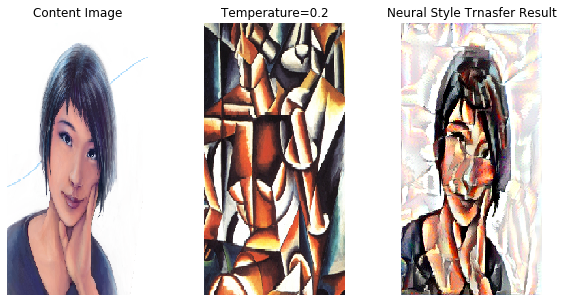

In [67]:
# Meural Style Transfer의 결과를 확인한다.
plt.figure(figsize=(10,5))

# Content Image
plot_1 = plt.subplot(1,3,1)
plot_1.imshow(load_img(target_image_path, target_size=(img_height, img_width)))
plot_1.axis('off')
plot_1.set_title('Content Image')

# Style Image
plot_2 = plt.subplot(1,3,2)
plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))
plot_2.axis('off')
plot_2.set_title('Temperature=0.2')

# Neural Style Transfer 결과
plot_3 = plt.subplot(1,3,3)
plot_3.imshow(img)
plot_3.axis('off')
plot_3.set_title('Neural Style Trnasfer Result')

plt.show()

### VAE
먼저 VAE의 약자를 살펴보게 되면 **Variational AutoEncoder**이다.  
기본적인 AutoEncoder에 대한 내용은 <a href="https://wjddyd66.github.io/pytorch/Pytorch-AutoEncoder/">Pytorch-AutoEncoder</a>, <a href="https://wjddyd66.github.io/tensorflow/Tensorflow-AutoEncoder/">Tensorflow-AutoEncoder</a>에서 다루었기 때문에 VAE랑 AutoEncoder의 차이점을 살펴보자.  

먼저 AutoEncode의 Network의 구조를 살펴보면 다음과 같다.  
<img src="https://i.imgur.com/mk074W5.jpg"><br>
사진 참조: <a href="https://subinium.github.io/Keras-8/#84-%EB%B3%80%EC%9D%B4%ED%98%95-%EC%98%A4%ED%86%A0%EC%9D%B8%EC%BD%94%EB%8D%94%EB%A5%BC-%EC%82%AC%EC%9A%A9%ED%95%9C-%EC%9D%B4%EB%AF%B8%EC%A7%80-%EC%83%9D%EC%84%B1">subinium 블로그</a><br>

기본적으로 Encoder를 통하여 상대적으로 Sparse한 Input Data를 Dense한 Compressed representation로 변형 후 Decoder를 통하여 원본 Image를 복원하는 Image-to-Image 기법 중 하나이다.  

**VAE의 Network 구조를 살펴보면 다음과 같다.**  
<img src="https://i.imgur.com/EEyWTOh.jpg"><br>
<img src="https://i.imgur.com/mk074W5.jpg"><br>
사진 참조: <a href="https://subinium.github.io/Keras-8/#84-%EB%B3%80%EC%9D%B4%ED%98%95-%EC%98%A4%ED%86%A0%EC%9D%B8%EC%BD%94%EB%8D%94%EB%A5%BC-%EC%82%AC%EC%9A%A9%ED%95%9C-%EC%9D%B4%EB%AF%B8%EC%A7%80-%EC%83%9D%EC%84%B1">subinium 블로그</a><br>

AutoEncoder와 같이 **Encoder를 통하여 Compressed representation으로 변경하는 것이 아닌 z_mean, z_log_var의 두개의 Parameter를 선택하는 데 사용한다.**  
이러한 2개의 Parameter를 통하여 Sompling한 Data가 AutoEncoder에서의 Compressed representation이다.  
즉, **Sparse한 Data를 Dense하게 표현하는데 있어서 Network의 출력이 아닌 Network의 출력에 대한 일정한 확률 분포에서 Data를 Sampling하겠다는 의미이다.**  

이러한 확률분포에서 Sampling을 하게 된다면 **GAN에서의 잠재변수 z(책에서는 개념 벡터)와 같은 Parameter도 같이 학습할 수 있고 평가 기준이 명확하기 때문에 학습이 안정적인편 이라고 평가된다.**  

#### Encoder
위의 내용을 간단하게 정리하자면 **Encoder를 통하여 얻은 z_mean, z_log_var를 통하여 확률분포를 만들고 Sampling을 실시한 Data를 Decoder에 넣어서 Image-to-Image구조의 VAE Network를 만든다.**  

위의 설명을 다시 수학적으로 나타내면 다음과 같다.  
Encoder의 역할은 데이터가 주어졌을 때 Decoder가 원래의 데이테로 잘 복원할 수 있는 z를 샘플링 할 수 있는 **이상적인 확률 분포 <span>$p(z|x)$</span>를 찾는 것 이다.**  
**이러한 확률적인 분포를 찾기 위하여 계산하기 쉬운 Gaussian 분포 <span>$q_{\phi}(z|x)$</span>를 정의하고 Encoder의 Parameter <span>$\phi$</span>를 조절하게 <span>$p(z|x) \leftarrow q_{\phi}(z|x)$</span>를 Training한다.**  
z의 평균과 분산은 우리가 정할 수 있다. 평균과 분산은 일치하되 거기서의 확률분포는 Training으로서 결정되는 것 이다.  
따라서 z의 평균과 분산은 계산하기 쉽게 각각 0,1로서 선언한다.  

위의 설명을 그림으로서 나타내면 아래와 같다.  
<img src="https://datascienceschool.net/upfiles/da522e75af6544c1a4ae09be69ed1a48.png"><br>
사진 출처: <a href="https://datascienceschool.net/view-notebook/c5248de280a64ae2a96c1d4e690fdf79/">데이터사이언스 스쿨</a><br>

아래 Code는 z의 차원을 2로서 고정시키고 Image-to-Image Network의 구성을 위해 CNN으로서 Model을 정의하였다.

In [3]:
# Hyperparameter 선언
img_shape = (28,28,1)
batch_size = 16
latent_dim = 2
input_img = keras.Input(shape=img_shape)

# Encoder Layer 선언
x = layers.Conv2D(32,3,padding='same',activation='relu')(input_img)
x = layers.Conv2D(64,3,padding='same',activation='relu',strides=(2,2))(x)
x = layers.Conv2D(64,3,padding='same',activation='relu')(x)
x = layers.Conv2D(32,3,padding='same',activation='relu')(x)

# Decoder에 사용하기 위하여 shape를 특정 변수에 선언한다.
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32,activation='relu')(x)

# 최종적인 확률 분포를 만들기 위한 평균과 분산을 선언한다.
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

#### Sampling
모든 Model은 HyperparameterTuning을 위하여 Training을 통해 Backpropagation을 진행한다.  
기본적인 Sampling을 한다고 가정하였을때 이러한 Backpropagation이 불가능 하므로 특정한 Sampling방법을 사용하여야 한다.  

이번 Code에서 사용할 Sampling방법은 reparameterization trick이다.  
먼저 최종적인 식을 살펴보면 다음과 같다.  
<p>$$z^{i,l} \text{~} N(u_i,\sigma_{i}^2) \rightarrow z^{i,l} = u_i + \sigma_{i} \odot \epsilon$$</p>
<p>$$\epsilon \text{~} N(0,1)$$</p>

위의 최종적인 식을 간단히 설명하자면 다음과 같다.  
- <span>$z^{i,l} \text{~} N(u_i,\sigma_{i}^2) \rightarrow z^{i,l}$</span>: Training할 분포에서 Sampling을 한다.
- <span>$u_i + \sigma_{i} \odot \epsilon$</span>: Sampling할 x의 값을 변경한다.

위와 같이 식을 변경한 이유는 다음과 같다.  
먼저 Gaussian 분포를 정의하면 다음과 같다.  
<p>$$\frac{1}{\sigma \sqrt{2\pi}}exp(-\frac{(x-u)^2}{2 \sigma^2})$$</p>
위와 같은 Gaussian 분포에서 X를 통해 Z를 정규화함으로써 평균이 0, 표준편차가 1인 정규분포를 만들기 위한 z-분포의 식은 다음과 같다.  
<p>$$Z = \frac{X-u}{\sigma}$$</p>
즉 위의 식에 대입하기 위하여 X를 <span>$u_i + \sigma_{i} \odot \epsilon$</span>로 바꾸게 되면 z-분포의 식을 얻을 수 있다.  

위와 같은 과정을 통해서 평균이 0, 표준편차가 1인 정규분포에서 Data를 Sampling함과 동시에 z_mean(<span>$u_i$</span>)와 z_log_var(<span>$\sigma_{i}$</span>)에 대하여 미분가능해지면서 Hyperparameter를 Tuning할 Backpropagation이 가능해진다.

In [4]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0],latent_dim),mean=0.,stddev=1.)
    
    return z_mean + K.exp(0.5*z_log_var)*epsilon

z = layers.Lambda(sampling)([z_mean,z_log_var])

#### Decoder
Decoder는 상대적으로 간단하다.  
위에서 Encoder -> Sampling의 결과로서 z를 얻을 수 있었다.  
이러한 z를 Input으로 받아 다시 Image의 크기로 원상복귀한다.

In [5]:
decoder_input = layers.Input(K.int_shape(z)[1:])

x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)

decoder = Model(decoder_input, x)
z_decoded = decoder(z)

decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 6272)              18816     
_________________________________________________________________
reshape_1 (Reshape)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 1)         289       
Total params: 28,353
Trainable params: 28,353
Non-trainable params: 0
_________________________________________________________________


#### LossFunction
LossFunction을 구현하기 전에 **ELBO(Evidence LowerBOund)** 에 대하여 알아야 한다.  

위에서 언급한 **<span>$p(z|x) \leftarrow q_{\phi}(z|x)$</span>를 Training한다.** 를 위하여 하나의 확률분포를 다른 확률분포로 만들기 위하여 CrossEntropy가 사용 될 것이라는 것을 예상은 하지만 정확히 어떻게 구현해야 하는지에 대한 내용이다.  
먼저 위에서 언급한 <span>$p(z|x) \leftarrow q_{\phi}(z|x)$</span>에서 우리가 알 수 있는 것은 <span>$q_{\phi}(z|x)$</span>뿐이다.  
따라서 우리가 구하고자 하는 <span>$p(z|x)$</span>에 대하여 알고있는 <span>$q_{\phi}(z|x)$</span>로서 식을 나타내야 한다.  

**전체 확률 법칙**  
가장 기본이 되는 이론부터 살펴보면 다음과 같다.  
표본공간 S가 있고 이 표본공간을 4개의 사건으로 나눠져 있다고 생각하자.  
<img src="https://postfiles.pstatic.net/20161013_128/mykepzzang_14762993174643mpvy_JPEG/%C7%C1%B7%B9%C1%A8%C5%D7%C0%CC%BC%C72.jpg?type=w2"><br>
사진 출처: <a href="https://blog.naver.com/PostView.nhn?blogId=mykepzzang&logNo=220834919339&parentCategoryNo=&categoryNo=38&viewDate=&isShowPopularPosts=false&from=postView">mykepzzang 블로그</a><br>
이 나눠진 4개의 영역을 포함하는 표본공간 S의 사건 A를 생각하면 다음과 같다.  
<img src="https://postfiles.pstatic.net/20161013_294/mykepzzang_1476299365916TH0Lh_JPEG/%C7%C1%B7%B9%C1%A8%C5%D7%C0%CC%BC%C71.jpg?type=w2"><br>
사진 출처: <a href="https://blog.naver.com/PostView.nhn?blogId=mykepzzang&logNo=220834919339&parentCategoryNo=&categoryNo=38&viewDate=&isShowPopularPosts=false&from=postView">mykepzzang 블로그</a><br>
위의 사진을 살펴보면 총 4개의 교집합이 생성되었다. 따라서 사건 A를 나타내는 방법은 다음과 같다.  
<p>$$P(A) = P((B_1 \cap A) \cup (B_2 \cap A) \cup (B_3 \cap A) \cup (B_4 \cap A))$$</p>
<p>$$P(A) = P(B_1 \cap A) + P(B_2 \cap A) + P(B_3 \cap A) + P(B_4 \cap A)$$</p>
<p>$$\because B_1 \cap A, B_2 \cap A, B_3 \cap A, B_4 \cap A \text{ 는 서로 배반}$$</p>
<p>$$P(A) = \sum_{i=1}^n P(B_i \cap A) = \sum_{i=1}^n P(B_i)P(A|B_i)$$</p>
<p>$$\because P(A|B_i) = \frac{P(A \cap B_i)}{P(B_i)}$$</p>
<br><br>

**Jensen's Inequality**  
먼저 <span>$log(p(x))$</span>에 위에서 설명한 전체 확률 법칙을 적용하면 다음과 같다.  
<p>$$log(p(x)) = log(\int p(x,z)\, dz) = log(\int p(x|z)p(z)\, dz)$$</p>

<span>$q_{\phi}(z|x)$</span>를 사용하여 위의 식을 나타내면 다음과 같다.  
<p>$$log(p(x)) = log(\int p(x|z)\frac{p(z)}{q_{\phi}(z|x)}q_{\phi}(z|x)\, dz)$$</p>

위의 식에서 <a href="https://en.wikipedia.org/wiki/Jensen%27s_inequality">Jensen's Inequality</a>하기 위하여 간략히 Jensen's Inequality의최종적인 식만 적으면 다음과 같다.(자세한 사항은 링크를 참조하시면 됩니다.)  
- X: random variable
- <span>$\phi$</span>: convex Function
<p>$$\phi(E[X]) \le E[\phi(X)]$$</p>

이제 위에서 구한 식 중 log함수는 Concave하므로 다음과 같은 식이 적용될 수 있다.(Convex Function과 반대)  
<p>$$log(p(x)) \ge \int log(p(x|z)\frac{p(z)}{q_{\phi}(z|x)})q_{\phi}(z|x)\, dz$$</p>
<p>$$log(p(x)) \ge \int log(p(x|z)q_{\phi}(z|x)\, dz - \int log(\frac{q_{\phi}(z|x)}{p(z)})q_{\phi}(z|x)\, dz$$</p>

위의 식에서 우변의 식을 **ELBO**라고 부른다.  
이 ELBO(<span>$\phi$</span>)값을 최대화 하는 <span>$\phi$</span>찾으면 우변과 좌변은 같게 된다.  
위의 식을 줄여서 사용하면 다음과 같다.  
<p>$$\int log(p(x|z)q_{\phi}(z|x)\, dz = \mathbb{E}_{q_{\phi}(z|x)}[log(p(x|z))]$$</p>
<p>$$\int log(\frac{q_{\phi}(z|x)}{p(z)})q_{\phi}(z|x)\, dz = KL(q_{\phi}(z|x)||p(z))$$</p>
Kullback-Leibler divergence(KL-Divergence)의 자세히 설명은 링크 참조: <a href="https://wjddyd66.github.io/pytorch/Pytorch-GAN/#%EC%82%AC%EC%A0%84%EC%A7%80%EC%8B%9D">KL-Divergence</a>)  

따라서 최종적인 ELBO(<span>$\phi$</span>)의 식은 다음과 같이 정의할 수 있다.  
<p>$$ELBO(\phi) = \mathbb{E}_{q_{\phi}(z|x)}[log(p(x|z))] - KL(q_{\phi}(z|x)||p(z))$$</p>
<br><br>

**Kullback-Leibler divergence(KL-Divergence)**  
log(p(x))부터 식을 전개한다.  
<p>$$log(p(x)) = \int log(p(x))q_{\phi}(z|x)\, dz$$</p>
<p>$$\because \int q_{\phi}(z|x)\, dz = 1$$</p>
<p>$$log(p(x)) = \int log(\frac{p(x,z)}{p(z|x)})q_{\phi}(z|x)\, dz$$</p>
<p>$$= \int log(\frac{p(x,z)}{q_{\phi}(z|x)}\frac{q_{\phi}(z|x)}{p(z|x)})q_{\phi}(z|x)\, dz$$</p>
<p>$$= \int log(\frac{p(x,z)}{q_{\phi}(z|x)})q_{\phi}(z|x)\, dz + \int log(\frac{q_{\phi}(z|x)}{p(z|x)})q_{\phi}(z|x)\, dz$$</p>

위의 식을 정리하게 되면  
<p>$$= \int log(\frac{p(x,z)}{q_{\phi}(z|x)})q_{\phi}(z|x)\, dz = ELBO(\phi)$$</p>
<p>$$\int log(\frac{q_{\phi}(z|x)}{p(z|x)})q_{\phi}(z|x)\, dz = KL(q_{\phi}(z|x)||p(z|x))$$</p>
<p>$$\therefore log(p(x)) = ELBO(\phi) + KL(q_{\phi}(z|x)||p(z|x))$$</p>
위의 KL-Divergence를 참조하게 되면 KL-Divergence값이 작을 수록 두 분포가 유사하다는 의미를 가지고 0이면 두 분포가 같다는 의미를 가진다고 설명하였다.  
즉, <span>$KL(q_{\phi}(z|x)||p(z|x))$</span>이 작을수록 처음부터 구하고자하는 <span>$p(z|x) \leftarrow q_{\phi}(z|x)$</span>이 성립하게 되고 이를 위해서는 <span>$ELBO(\phi)$</span>의 값이 최대화가 되어야 한다는 의미이다.  

위의 설명을 그림으로 나타내면 아래와 같다.  
<img src="https://datascienceschool.net/upfiles/2b17600871204ad69d074389bab587c4.png"><br>
사진 출처: <a href="https://datascienceschool.net/view-notebook/c5248de280a64ae2a96c1d4e690fdf79/">데이터사이언스 스쿨</a>
<br><br>

**LossFunction**  
최종적인 LossFunction은 <span>$ELBO(\phi)$</span>의 값이 최대화해야하는 방향으로 정하였다.  
먼저 <span>$ELBO(\phi)$</span>의 식을 다시 살펴보면 다음과 같다.  
<p>$$ELBO(\phi) = \mathbb{E}_{q_{\phi}(z|x)}[log(p(x|z))] - KL(q_{\phi}(z|x)||p(z))$$</p>
위의 식에서 <span>$p(x|z)$</span>의 의미를 살펴보게 되면 z를 Input으로 넣어서 Output인 x를 출력하는 Decoder의 형태로 나타낼 수 있다.  
Decoder의 Hyperparameter를 <span>$\theta$</span>라고 생각하면 최종적인 LossFunction은 다음과 같다.  
(Encoder의 경우에도 <span>$q_{\phi}(z|x)$</span> 라고 정의하였다. 즉, x를 input으로 넣어서 z를 출력한다. Hpyerparameter는 <span>$\phi$</span>라고 생각할 수 있다.)  
<p>$$L_{(\theta,\phi,x^i)} = -\mathbb{E}_{q_{\phi}(z|x^i)}[log(p_{\theta}(x^i|z))] + KL(q_{\phi}(z|x^i)||p(z))$$</p>
위의 식을 Training시키기 위하여 식을 변경하게 되면 다음과 같다.  
<p>$$\theta^*, \phi^* = argmax_{\theta, \phi} \sum_{i=1}^N L(\theta,\phi,x^i)$$</p>
위의 최종적인 LossFunction에서 <span>$\mathbb{E}_{q_{\phi}(z|x^i)}[log(p_{\theta}(x^i|z))]$</span>, <span>$KL(q_{\phi}(z|x^i)||p(z))$</span>을 따로 생각하여 계산하자.  
<br>

**LossFunction1(<span>$KL(q_{\phi}(z|x^i)||p(z))$</span>)**  
Encoder부분에서 <span>$q_{\phi}(z|x^i), p(z)$</span>를 평균 0, 분산 1인 정규분포로서 가정하였다.  
<a href="https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence#Multivariate_normal_distributions"></a>를 참조하여 식을 변형하면 다음과 같이 나타낼 수 있다.  
<p>$$KL(q_{\phi}(z|x^i)||p(z))$$</p>
<p>$$= \frac{1}{2}\sum_{j=1}^{j}(u_{i,j}^2+\sigma_{i,j}^2 - ln(\sigma_{i,j}^2)-1)$$</p>
<br>

**LossFunction2(<span>$\mathbb{E}_{q_{\phi}(z|x^i)}[log(p_{\theta}(x^i|z))]$</span>)**  
<p>$$\mathbb{E}_{q_{\phi}(z|x^i)}[log(p_{\theta}(x^i|z))] = \int log(p_{\theta}(x|z)q_{\phi}(z|x)\, dz$$</p>
<p>$$ = \int log(p_{\theta}(x|z)\, dz$$</p>
<p>$$\because \int q_{\phi}(z|x)\, dz = 1$$</p>

위의 식을 Mini-Batch 처리를 한다면 다음과 같다.(L = BatchSize, 대부분 L=1로 두고 계산한다.)  
<p>$$\frac{1}{L} \sum_{z^{i,l}}log(p_{\theta}(x^i|z^{i,l})\, dz$$</p>

위의 식에서 Mini-Batch Size L=1로 가정하고, p(x) = Bernoulli분포로 가정한다.  
Bernoulli 분포는 1 아니면 0으로서의 확률값을 가지는 확률분포를 의미하게 된다.  
Decoder의 마지막 단을 살펴보게 되면 <code>x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)</code>로서 0 ~ 1의 값을 가지는 Sigmoid로서 Activation Function으로서 설정하였다.  

<p>$$\int log(p_{\theta}(x^i|z^i)\, dz = \sum_{j=1}^D log(p_{\theta}(x_{i,j}|z^i)$$</p>
<p>$$= \sum_{j=1}^D log(p_{i,j}^{x_{i,j}}(1-p_{i,j}^{1-x_{i,j}}))$$</p>
<p>$$= \sum_{j=1}^D x_{i,j}log(p_{i,j}) + (1-x_{i,j})(1-p_{i,j}))$$</p>

위의 식을 살펴보면 Decoder의 출력인 <span>$p_{i,j}$</span>와 Input인 <span>$x_{i,j}$</span>의 CrossEntropy인 것을 확인할 수 있다.(따라서 나중에 Input Image또한 0~1사이의 값으로 변화시켜야 한다.)

In [9]:
class CustomVariationalLayer(layers.Layer):

    def vae_loss(self, x, z_decoded):
        # Input Image
        x = K.flatten(x)
        
        # Decoder 출력
        z_decoded = K.flatten(z_decoded)
        
        # LossFunction2: Input Image와 Decoder출력의 Crossentropy
        cross_entropy_loss = metrics.binary_crossentropy(x, z_decoded)
        
        # LossFunction1
        kl_loss = -5e-4 * K.mean(1 + z_log_var -
                                 K.square(z_mean) - K.exp(z_log_var), axis=-1)
        
        # 최종적인 Loss 반환
        return K.mean(cross_entropy_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x


y = CustomVariationalLayer()([input_img, z_decoded])

#### VAE Model정의 및 Train
Dataset은 MNIST Dataset으로서 사용한다.  
이번 Model에서는 위에서 정의한 LossFunction인 CustomVariationalLayer()에서 Loss를 직접 사용하므로 Model에 적용하지는 않는다.(<code>loss = None</code>)  
또한, Image-to-Image의 VAE구조이므로 Target Image는 정의하지 않아도 된다.

In [11]:
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

from keras.datasets import mnist

(x_train, _), (x_test, y_test) = mnist.load_data()


x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))
print(x_train.shape, x_test.shape)

vae.fit(x=x_train, y=None, shuffle=True, epochs=10,
        batch_size=batch_size, validation_data=(x_test, None))

/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output custom_variational_layer_4 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to custom_variational_layer_4.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
____________________________________________________________________________________________

#### z를 통한 Model결과 시각화하기
z의 값을 변화시켜가면서 Decoder가 출력하는 결과를 확인한다.  
아래 <code>scipy.stats.norm</code>을 사용하여 사전에 가정하였던 평균이 0, 표준편차가 1인 정규분포에서의 일정한 간격으로의 값을 Sampling한다.  
결과를 살펴보게되면 GAN에서와 마찬가지로 Z의 변화에 따라서 점차 Image가 변하는 것을 확인할 수 있다.

참조: <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html">scipy.stats.norm</a>

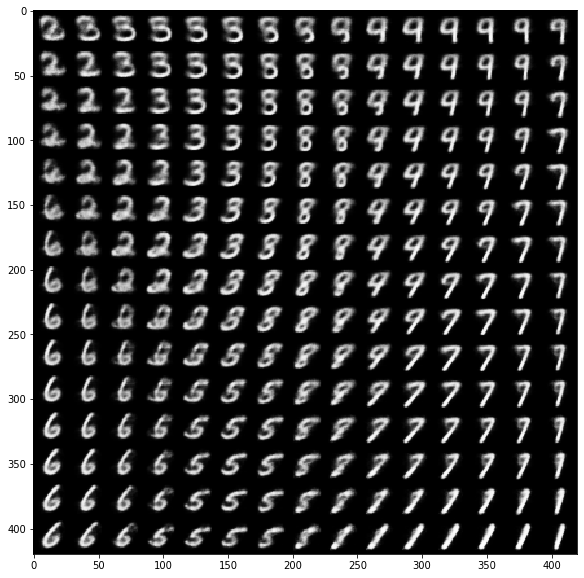

In [12]:
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)

        digit = x_decoded[0].reshape(digit_size, digit_size)

        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap="Greys_r")
plt.show()